In [1]:
!pip install kaggle -q
!export KAGGLE_USERNAME=saikowndinya
!export KAGGLE_KEY=de0e780aef58aa3ea09e05bc35e9c9da
!kaggle datasets download "gunavenkatdoddi/eye-diseases-classification"
#kaggle kernels pull danishmubashar/eye-disease-mobilenetv2-model

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 733M/736M [00:33<00:00, 23.7MB/s]
100% 736M/736M [00:33<00:00, 22.8MB/s]


In [2]:
!unzip -q eye-diseases-classification.zip

In [3]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

# Visualization

In [4]:
labels = ["Normal", "Glaucoma", "Cataract", "Diabetic Retinopathy"]
counts = [1074,1007, 1038, 1098]

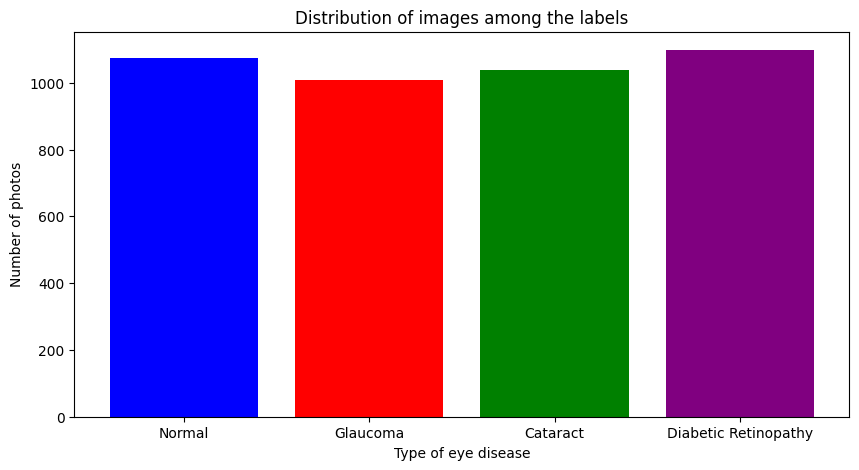

In [5]:
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Type of eye disease")
plt.ylabel("Number of photos")
plt.title("Distribution of images among the labels")
plt.show()

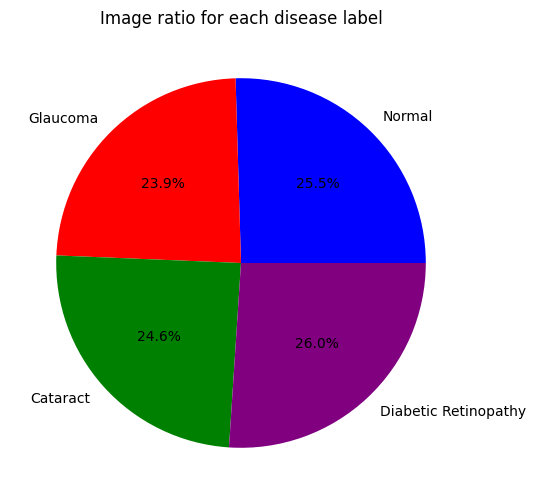

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'red', 'green', 'purple'])
plt.title("Image ratio for each disease label")
plt.show()

In [7]:
def visualize_images(path, target_size=(250, 250), num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    selected_images = image_filenames[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    plt.tight_layout()
    plt.show()

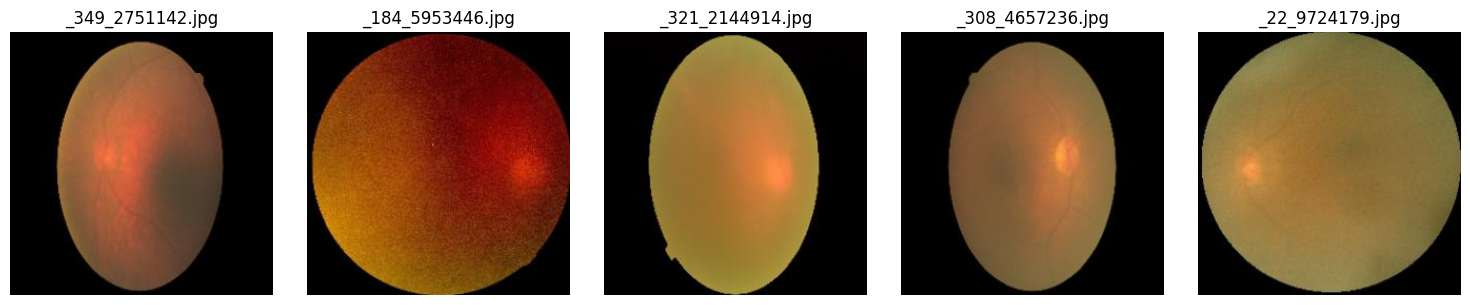

In [8]:
cataract = "/content/dataset/cataract"
visualize_images(cataract, num_images=5)

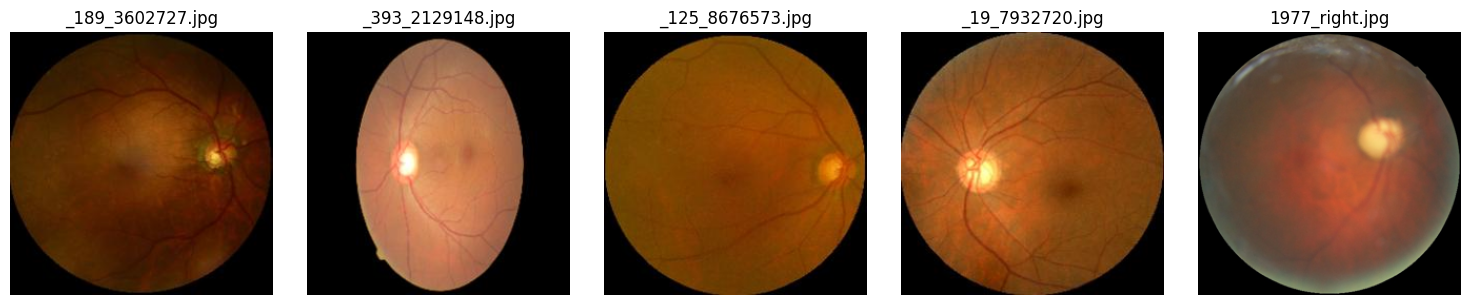

In [9]:
glaucoma = "/content/dataset/glaucoma"
visualize_images(glaucoma, num_images=5)


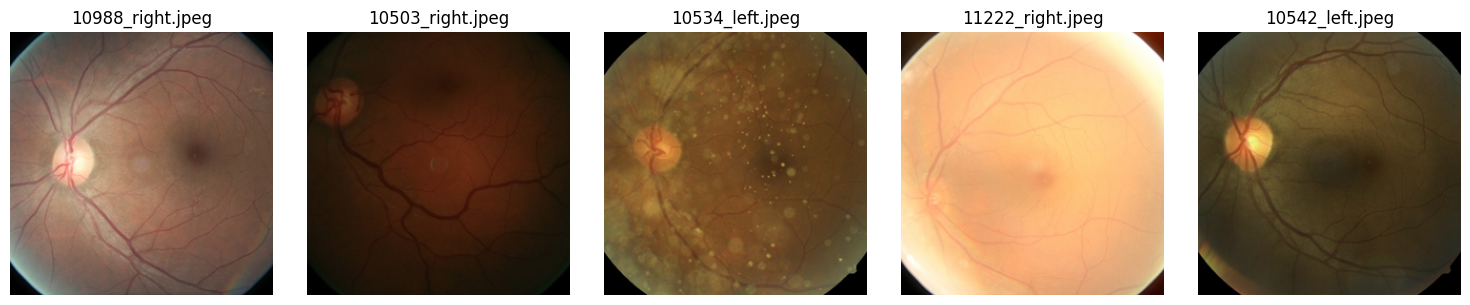

In [10]:
diabetic_retinopathy= "/content/dataset/diabetic_retinopathy"
visualize_images(diabetic_retinopathy, num_images=5)

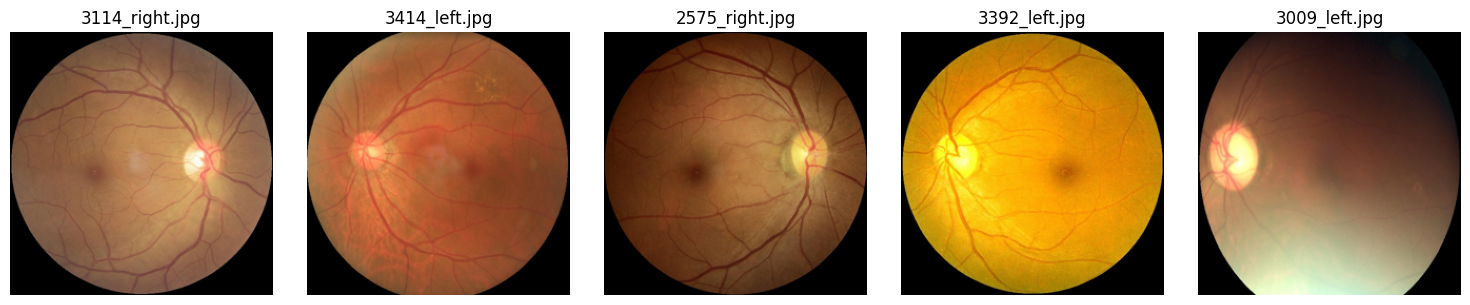

In [11]:
normal= "/content/dataset/normal"
visualize_images(normal, num_images=5)

# Dataset creation

In [12]:
data = "/content/dataset"
rescale = tf.keras.layers.Rescaling(1./255)
# Function to load dataset
def load_dataset(directory, subset=None, validation_split=0.25, batch_size=32, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        batch_size=batch_size,
        image_size=(256, 256),
        validation_split=validation_split if subset else None,
        subset=subset,
        seed=123,
        label_mode='categorical',
        shuffle=shuffle
    ).map(lambda x, y: (rescale(x), y))
train_ds = load_dataset(data, subset="training")
validation_ds = load_dataset(data, subset="validation")

Found 4217 files belonging to 4 classes.
Using 3163 files for training.
Found 4217 files belonging to 4 classes.
Using 1054 files for validation.


# Model Creation And Training

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])
# ADD RNN
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Reshape((64, 1)),  # Reshape for RNN input
#     tf.keras.layers.SimpleRNN(32),  # Simple RNN layer
#     tf.keras.layers.Dense(4, activation='softmax')  # Output layer
# ])

model = keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="valid"),
    tf.keras.layers.Conv2D(64, (1, 1), activation="relu", padding="valid"),
    tf.keras.layers.Conv2D(128, (1, 1), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation="softmax")
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 252, 252, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 60, 60, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,575,780 (112.82 MB)

 Trainable params: 29,575,652 (112.82 MB)

 Non-trainable params: 128 (512.00 B)

None


In [ ]:
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping("val_accuracy", patience=5, verbose=1),
                        tf.keras.callbacks.ModelCheckpoint("Best model.keras", monitor="val_accuracy", save_best_only=True)
                    ],
                    epochs=50)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 332ms/step - accuracy: 0.4885 - loss: 2.2141 - val_accuracy: 0.2827 - val_loss: 1.3223
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.7242 - loss: 0.6307 - val_accuracy: 0.5408 - val_loss: 1.1074
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.8134 - loss: 0.4795 - val_accuracy: 0.6385 - val_loss: 0.8511
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.8383 - loss: 0.4080 - val_accuracy: 0.6793 - val_loss: 0.6911
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 176ms/step - accuracy: 0.8629 - loss: 0.3416 - val_accuracy: 0.6565 - val_loss: 0.7661
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.8849 - loss: 0.2917 - val_accuracy: 0.7913 - val_loss: 0.4656
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.9272 - loss: 0.2039 - val_accuracy: 0.8691 - val_loss: 0.3594
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.9480 - loss: 0.1485 - val_accu

In [ ]:
model.save('Final eye_disease_model.keras')

# Loading best model

In [13]:
!sha256sum "Best model.keras"

4940b784699c53adcf0dd153a2a5a4d5a921a97f7ea022dc33b0b01d3fb163a7  Best model.keras


In [14]:
best_model = tf.keras.models.load_model("Best model.keras")

In [15]:
best_model.evaluate(validation_ds, return_dict=True)

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.8695 - loss: 1.0951


{'accuracy': 0.877609133720398, 'loss': 0.9707753658294678}

In [35]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=99>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
Raw Predictions: [[9.9913460e-01 4.3246905e-07 5.0874501e-06 8.5986743e-04]]
Predicted Class: Cataract
Confidence: 99.91


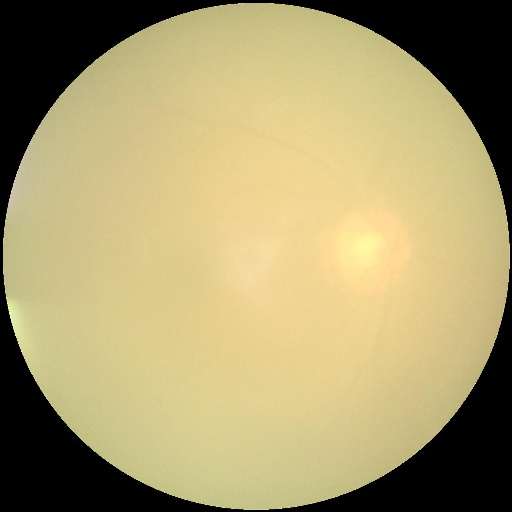

In [49]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/Best model.keras")  # Ensure correct model path

# Class labels
class_labels = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal Image"]

def predict_image(image_path):
    """Predicts the class of an input image."""
    img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    img = tf.keras.utils.img_to_array(img, dtype=np.float64) / 255.0
    predictions = model.predict(np.array([img]))

    # Print raw predictions for debugging
    print(f"Raw Predictions: {predictions}")

    class_index = np.argmax(predictions)  # Get the highest probability index
    return class_labels[class_index], np.max(predictions)

# Example usage
image_path = "/content/dataset/cataract/1126_right.jpg"  # Replace with actual image path
result, confidence = predict_image(image_path)
print(f"Predicted Class: {result}\nConfidence: {confidence * 100:.2f}")

tf.keras.utils.load_img(image_path)
